In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ranksums, ttest_ind, pearsonr, f, f_oneway, ttest_rel, wilcoxon
from statsmodels.stats.multicomp import MultiComparison
label_font = {'family': 'Times New Roman', 'size': 32}

In [2]:
def formatnum(x, pos):
    if x == 0:
        return 0
    return '$%.1f$x$10^{5}$' % (x/1e5)
formatter = FuncFormatter(formatnum)

def ftest(s1, s2):
    '''F检验样本总体方差是否相等'''
    F = np.var(s1) / np.var(s2)
    v1 = len(s1) - 1
    v2 = len(s2) - 1
    p_val = 1 - 2 * abs(0.5 - f.cdf(F, v1, v2))
    print(p_val)
    if p_val < 0.05:
        print('Reject the Null Hypothesis.')
        equal_var = False
    else:
        print('Accept the Null Hypothesis.')
        equal_var = True
    return equal_var

def ttest_ind_func(s1, s2):
    '''t检验独立样本所需的两个总体均值是否存在差异'''
    equal_var = ftest(s1, s2)
    print('Null Hypothesis: mean(s1) = mean(s2), α=0.5')
    ttest, pval = ttest_ind(s1, s2, equal_var=equal_var)
    if pval < 0.05:
        print("Reject the Null Hypothesis.")
    else:
        print("Accept the Null Hypothesis.")
    return ttest, pval


def box_plot_dict(plot_data, ylabel, formatter=None, yscale='log'):
    #fig, ax = plt.subplots(figsize=(16, 9))
    colors = ['green', 'orange', 'red', 'black', 'blue', 'brown']
    p = 0
    for (k, v) in plot_data.items():
        plt.boxplot(v, positions=[p], labels=[k], showfliers=False)
        plt.scatter(p * np.ones_like(v) + (np.random.random(len(v)) - 0.5) * 0.1, v, alpha=0.2, color=colors[p])
        p = p + 1
    plt.ylabel(ylabel, label_font)
    plt.tick_params(labelsize=16)
    plt.yscale(yscale)
    if formatter:
        ax=plt.gca()
        ax.yaxis.set_major_formatter(formatter)
        

def get_age_group(age):
    group = ''
    if age > 70:
        group = '> 70 yr'
    elif age > 60:
        group = '60-70 yr'
    elif age > 50:
        group = '50-60 yr'
    elif age > 40:
        group = '40-50 yr'
    else:
        group = '< 40 yr'
    return group

In [3]:
data_severe = pd.read_csv('merge_data.csv', index_col=0)
data_mild = pd.read_csv('merge_data_mild.csv', index_col=0)
data_0515 = pd.read_csv('merge_data_0515.csv', index_col=0)
data_0608 = pd.read_csv('merge_data_0608.csv', index_col=0)
data_0611 = pd.read_csv('merge_data_0611.csv', index_col=0)
data_0614 = pd.read_csv('merge_data_0614.csv', index_col=0)
data_sp = pd.read_csv('merge_data_sp.csv', index_col=0)
data = pd.concat([data_severe, data_mild, data_0515, data_0608, data_0611, data_0614, data_sp], axis=0)

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [4]:
clean_data = data[data['ratio'] < 1.0]
clean_data = clean_data[clean_data['check'] >= 0]
clean_data = clean_data.drop_duplicates(subset=['filename'], keep='first', inplace=False)

In [5]:
clean_data

,Age,InstitutionName,Manufacturer,PatientBirthDate,PatientID,PatientSex,Severe,StudyDate,StudyID,StudyTime,...,right_lesion,right_lung,severe,shape,slice,spacing,studyDate,weighted_lesion,weighted_lung_lesion,z
0,64.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,NaN,2020035234,M,0,2020/2/2,NaN,181925.81,...,1.236617e+06,4.779453e+06,0.0,"(474, 512, 512)",474,"(0.753000020980835, 0.753000020980835, 0.8125)",NaN,151280.84630,130789.212200,251.883951
1,64.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1955/11/24,2020035234,M,1,2020/2/5,NaN,133130.00,...,1.119875e+06,4.328251e+06,1.0,"(468, 512, 512)",468,"(0.7789999842643738, 0.7789999842643738, 0.6875)",NaN,380547.77860,340194.310700,240.033752
2,36.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,NaN,2020035295,F,0,2020/2/3,NaN,152915.90,...,1.459113e+04,6.050851e+06,0.0,"(396, 512, 512)",396,"(0.753000020980835, 0.753000020980835, 0.8125)",NaN,11801.07948,92.724321,368.183721
3,36.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1983/2/13,2020035295,F,1,2020/2/6,NaN,111341.46,...,1.224816e+04,5.079235e+06,1.0,"(468, 512, 512)",468,"(0.75, 0.75, 0.6875)",NaN,20820.05790,11150.366360,238.977506
4,68.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1951/9/21,2020034800,M,0,2020/2/13,NaN,144044.23,...,9.400646e+05,6.064816e+06,0.0,"(468, 512, 512)",468,"(0.8320000171661377, 0.8320000171661377, 0.6875)",NaN,268307.92280,224691.435100,250.748492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,82.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1937/3/16,2020035360,M,2,2020/2/28,9.200000e+15,742.10,...,3.081773e+06,9.925418e+06,NaN,"(468, 512, 512)",468,"(0.7870000004768372, 0.7870000004768372, 0.6875)",2020/2/28,608801.31350,511881.494700,248.747335
9,82.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1937/3/16,2020035360,M,2,2020/3/9,9.200000e+15,95115.51,...,3.461196e+07,1.114742e+08,NaN,"(103, 512, 512)",103,"(0.9779999852180481, 0.9779999852180481, 5.0)",2020/3/9,57370.65877,18941.008270,35.169226
11,83.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1937/3/16,2020035360,M,2,2020/3/31,9.200000e+15,160230.45,...,3.535952e+06,1.138818e+07,NaN,"(468, 512, 512)",468,"(0.8429999947547913, 0.8429999947547913, 0.6875)",2020/3/31,307255.61050,281070.900500,257.254053
12,76.0,ShanghaiP.H.ClinicalCenter,Hitachi Medical Corporation,1944/2/15,2020037365,M,2,2020/3/13,9.200000e+15,144734.31,...,3.890723e+05,9.563929e+05,NaN,"(468, 512, 512)",468,"(0.8259999752044678, 0.8259999752044678, 0.6875)",2020/3/13,484002.64160,329839.499000,224.819049


In [6]:
mild_data = clean_data[clean_data['Severe'] == 0]
severe_data = clean_data[clean_data['Severe'] == 1]
critical_data = clean_data[clean_data['Severe'] == 2]

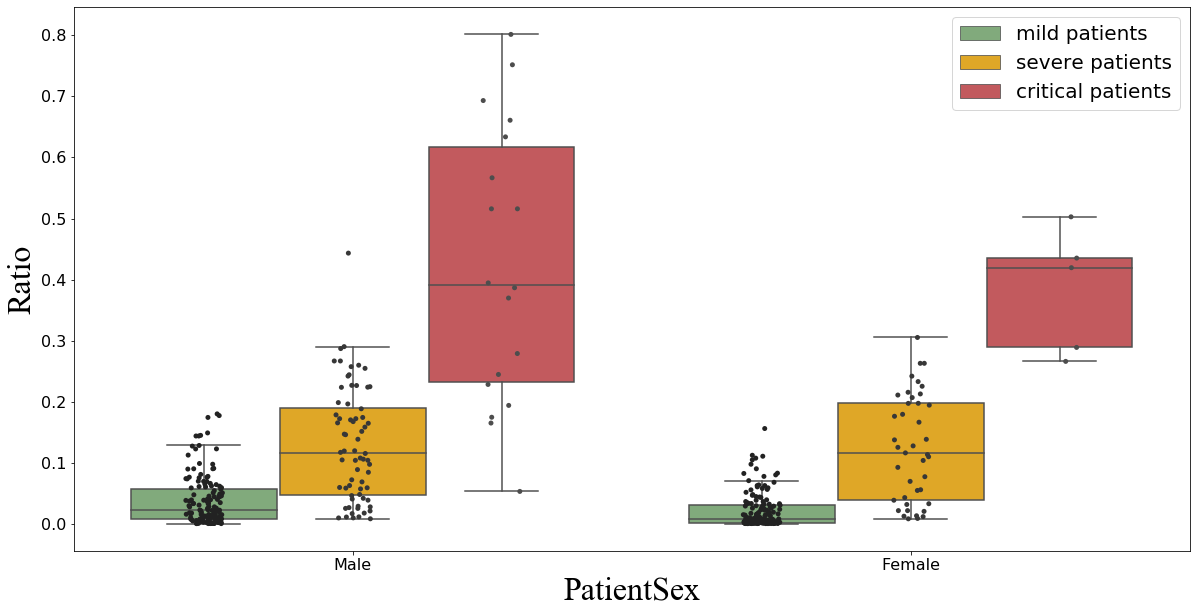

In [7]:
colors = ["faded green", "amber", "faded red", "medium blue"]
severes = ["mild patients", 'severe patients', 'critical patients']
#sns.palplot(sns.xkcd_palette(colors))
plt.figure(figsize=(20,10))
#sns.set(style="ticks")
#sns.set(font_scale=1.5)
dx = sns.boxplot(x="PatientSex", hue="Severe", y="ratio", data=clean_data, palette=sns.xkcd_palette(colors),
                 boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(x="PatientSex", hue="Severe", y="ratio", data=clean_data,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
handles, _ = dx.get_legend_handles_labels()
dx.legend(handles, severes, fontsize=20)
dx.set(xticklabels=['Male','Female'])
plt.xlabel('PatientSex', label_font)
plt.ylabel('Ratio', label_font)
plt.tick_params(labelsize=16)
#dx.set_yscale("log")

In [8]:
analysisRatio = clean_data.copy()
analysisRatio['ratioType'] = 0

analysisConsolidation = clean_data.copy()
analysisConsolidation['ratioType'] = 1
analysisConsolidation['ratio'] = analysisConsolidation['lesion_consolidation']/analysisConsolidation['lung']

analysisWeighted = clean_data.copy()
analysisWeighted['ratioType'] = 2
analysisWeighted['ratio'] = analysisWeighted['lesion_consolidation']/analysisWeighted['lung']
analysisAll = pd.concat([analysisRatio, analysisConsolidation, analysisWeighted], axis=0)

[(-0.1, 1.0)]

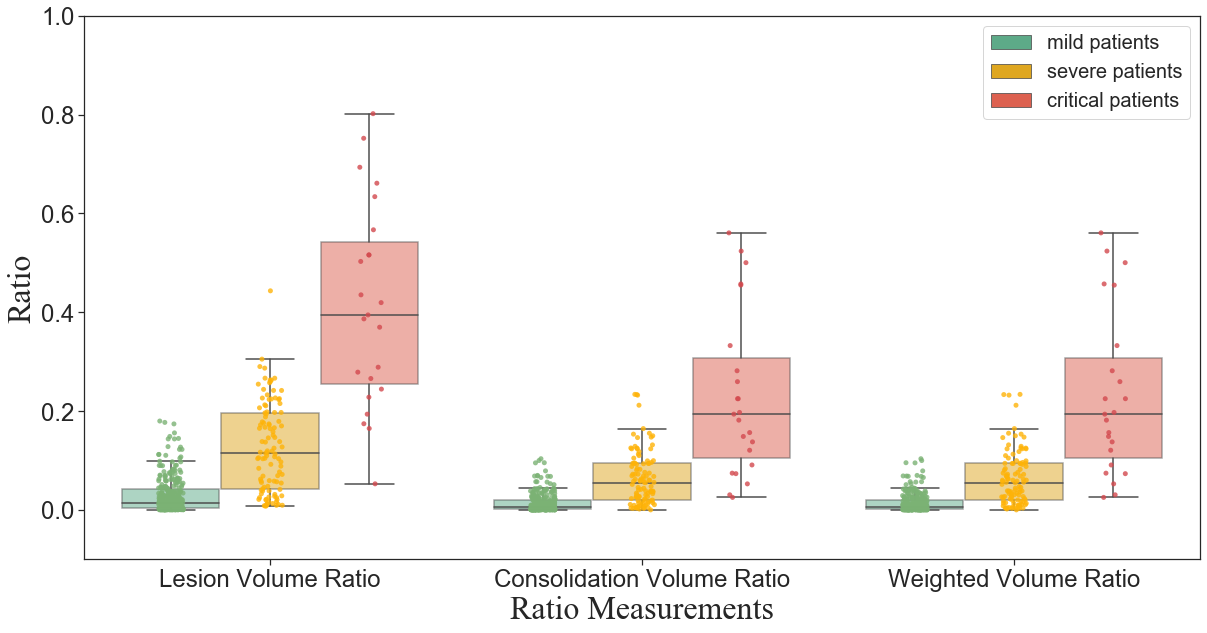

In [9]:
colors = [sns.color_palette('BuGn_r')[2], sns.color_palette('Wistia_r')[2], sns.color_palette('Reds_r')[2], sns.color_palette('Greys_r')[2]]
point_colors = ['faded green', 'amber', 'faded red', 'black']
severes = ["mild patients", 'severe patients', 'critical patients']
plt.figure(figsize=(20, 10))
sns.set(style="ticks")
#sns.set(font_scale=1.5)
dx = sns.boxplot(x='ratioType', hue='Severe', y='ratio', data=analysisAll, palette=sns.color_palette(colors),
                 boxprops=dict(alpha=0.5),showfliers = False)
dx = sns.stripplot(x='ratioType', hue='Severe', y='ratio', data=analysisAll, jitter=True, palette=sns.xkcd_palette(point_colors), dodge=True, marker='o',  alpha=0.8)
handles, _ = dx.get_legend_handles_labels()
dx.set(xticklabels=['Lesion Volume Ratio','Consolidation Volume Ratio', 'Weighted Volume Ratio'])
dx.legend(handles, severes, fontsize=20)
plt.xlabel('Ratio Measurements', label_font)
plt.ylabel('Ratio', label_font)
plt.tick_params(labelsize=24)
#dx.set_yscale("log")
dx.set(ylim=(-0.1, 1.0))

In [10]:
print(ranksums(mild_data['ratio'], severe_data['ratio']))
print(ranksums(mild_data['lesion_consolidation']/mild_data['lung'], severe_data['lesion_consolidation']/severe_data['lung']))
print(ranksums(mild_data['weighted_lesion']/mild_data['lung'], severe_data['weighted_lesion']/severe_data['lung']))

RanksumsResult(statistic=-11.05256712503459, pvalue=2.1303442773700557e-28)
RanksumsResult(statistic=-10.775077141895425, pvalue=4.51403573366965e-27)
RanksumsResult(statistic=-10.959443367981107, pvalue=5.986644782653753e-28)


In [11]:
print(ranksums(mild_data['ratio'], critical_data['ratio']))
print(ranksums(mild_data['lesion_consolidation']/mild_data['lung'], critical_data['lesion_consolidation']/critical_data['lung']))
print(ranksums(mild_data['weighted_lesion']/mild_data['lung'], critical_data['weighted_lesion']/critical_data['lung']))

RanksumsResult(statistic=-7.845380643321938, pvalue=4.3164221106907854e-15)
RanksumsResult(statistic=-7.702653648050237, pvalue=1.3326922398601891e-14)
RanksumsResult(statistic=-7.737184372712745, pvalue=1.016426108705928e-14)


In [12]:
print(ranksums(severe_data['ratio'], critical_data['ratio']))
print(ranksums(severe_data['lesion_consolidation']/severe_data['lung'], critical_data['lesion_consolidation']/critical_data['lung']))
print(ranksums(severe_data['weighted_lesion']/severe_data['lung'], critical_data['weighted_lesion']/critical_data['lung']))

RanksumsResult(statistic=-6.1520987835374825, pvalue=7.646422406712486e-10)
RanksumsResult(statistic=-5.318220937694762, pvalue=1.0478678143394194e-07)
RanksumsResult(statistic=-5.588181391384851, pvalue=2.294598977840673e-08)


E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
E:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


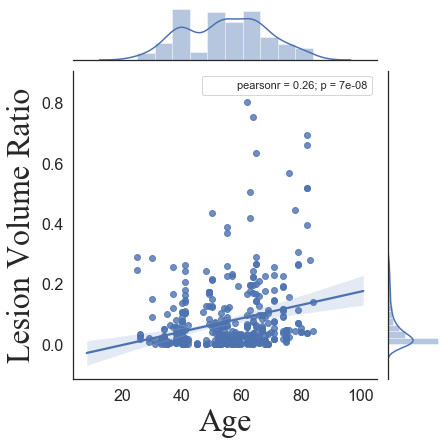

In [13]:
sns.set(style='white')
sns.jointplot(x='Age', y='ratio', data=clean_data, kind='reg', stat_func=pearsonr)
ax = plt.gca()
ax.set_ylabel('Lesion Volume Ratio', label_font)
ax.set_xlabel('Age', label_font)
plt.tick_params(labelsize=16)

In [14]:
data_20_30 = clean_data[(clean_data['Age'] > 20) & (clean_data['Age'] <= 30)]
data_30_40 = clean_data[(clean_data['Age'] > 30) & (clean_data['Age'] <= 40)]
data_40_50 = clean_data[(clean_data['Age'] > 40) & (clean_data['Age'] <= 50)]
data_50_60 = clean_data[(clean_data['Age'] > 50) & (clean_data['Age'] <= 60)]
data_60_70 = clean_data[(clean_data['Age'] > 60) & (clean_data['Age'] <= 70)]
data_70 = clean_data[clean_data['Age'] > 70]
data_40 = clean_data[clean_data['Age'] <= 40]

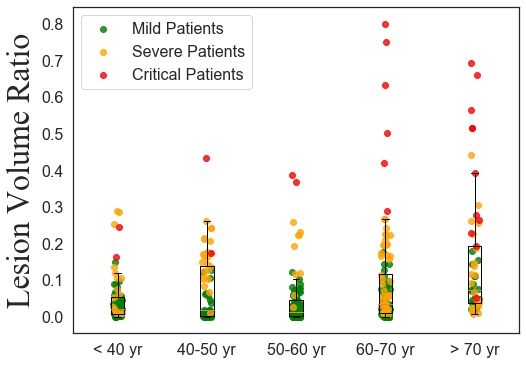

In [15]:
plot_data = {'< 40 yr': data_40,
             '40-50 yr': data_40_50,
             '50-60 yr': data_50_60, 
             '60-70 yr': data_60_70, 
             '> 70 yr': data_70}

fig, ax = plt.subplots(figsize=(8, 6))
p = 0
for (k, v) in plot_data.items():
    d = v['ratio']
    m = v[v['Severe'] == 0]['ratio']
    s = v[v['Severe'] == 1]['ratio']
    c = v[v['Severe'] == 2]['ratio']
    ax.boxplot(d, positions=[p], labels=[k], showfliers=False)
    if p == 0:
        ax.scatter(p * np.ones_like(m) + (np.random.random(len(m)) - 0.5) * 0.1, m, c='green', alpha=0.8, label='Mild Patients')
        ax.scatter(p * np.ones_like(s) + (np.random.random(len(s)) - 0.5) * 0.1, s, c='orange', alpha=0.8, label='Severe Patients')
        ax.scatter(p * np.ones_like(c) + (np.random.random(len(c)) - 0.5) * 0.1, c, c='red', alpha=0.8, label='Critical Patients')
    else:
        ax.scatter(p * np.ones_like(m) + (np.random.random(len(m)) - 0.5) * 0.1, m, c='green', alpha=0.8)
        ax.scatter(p * np.ones_like(s) + (np.random.random(len(s)) - 0.5) * 0.1, s, c='orange', alpha=0.8)
        ax.scatter(p * np.ones_like(c) + (np.random.random(len(c)) - 0.5) * 0.1, c, c='red', alpha=0.8)
    p = p + 1
ax.set_ylabel('Lesion Volume Ratio', label_font)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

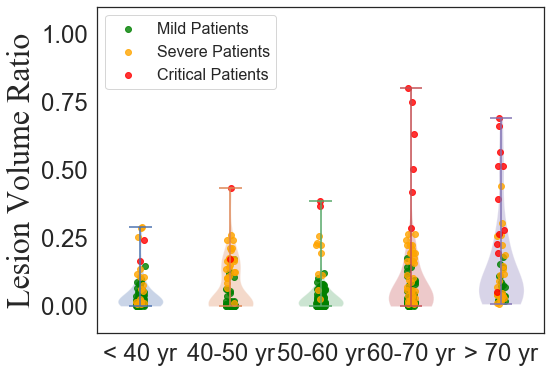

In [19]:
plot_data = {'< 40 yr': data_40,
             '40-50 yr': data_40_50,
             '50-60 yr': data_50_60, 
             '60-70 yr': data_60_70, 
             '> 70 yr': data_70}

fig, ax = plt.subplots(figsize=(8, 6))
p = 0
for (k, v) in plot_data.items():
    d = v['ratio']
    m = v[v['Severe'] == 0]['ratio']
    s = v[v['Severe'] == 1]['ratio']
    c = v[v['Severe'] == 2]['ratio']
    parts = plt.violinplot(d, positions=[p])
    dot1 = plt.scatter(p * np.ones_like(m) + (np.random.random(len(m)) - 0.5) * 0.1, m, c='green', alpha=0.8, label='Mild Patients')
    dot2 = plt.scatter(p * np.ones_like(s) + (np.random.random(len(s)) - 0.5) * 0.1, s, c='orange', alpha=0.8, label='Severe Patients')
    dot3 = plt.scatter(p * np.ones_like(c) + (np.random.random(len(c)) - 0.5) * 0.1, c, c='red', alpha=0.8, label='Critical Patients')
    p = p + 1

ax.set_ylabel('Lesion Volume Ratio', label_font)
ax.set_xticklabels([0] + list(plot_data.keys()))
plt.tick_params(labelsize=24)
plt.ylim((-0.1, 1.1))
plt.legend(handles=[dot1, dot2, dot3], fontsize=16)

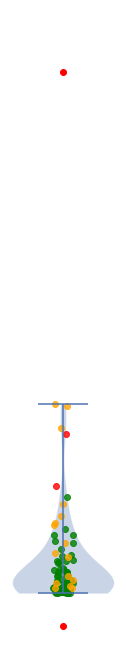

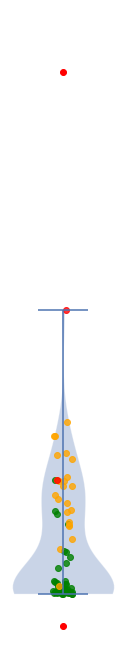

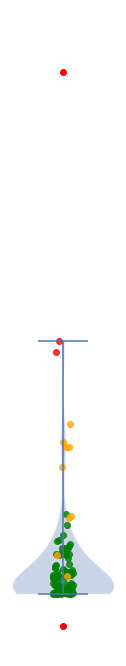

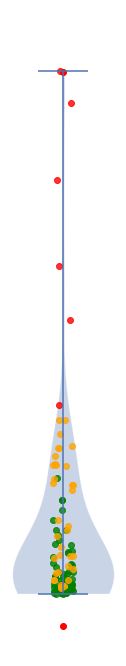

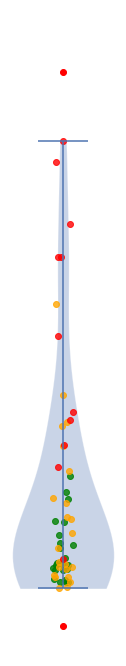

In [35]:
plot_data = {'< 40 yr': data_40,
             '40-50 yr': data_40_50,
             '50-60 yr': data_50_60, 
             '60-70 yr': data_60_70, 
             '> 70 yr': data_70}

for k, v in plot_data.items():
    fig, ax = plt.subplots(figsize=(2, 12))
    d = v['ratio']
    m = v[v['Severe'] == 0]['ratio']
    s = v[v['Severe'] == 1]['ratio']
    c = v[v['Severe'] == 2]['ratio']
    plt.violinplot(d, positions=[1])
    dot1 = plt.scatter(np.ones_like(m) + (np.random.random(len(m)) - 0.5) * 0.1, m, c='green', alpha=0.8, label='Mild Patients')
    dot2 = plt.scatter(np.ones_like(s) + (np.random.random(len(s)) - 0.5) * 0.1, s, c='orange', alpha=0.8, label='Severe Patients')
    dot3 = plt.scatter(np.ones_like(c) + (np.random.random(len(c)) - 0.5) * 0.1, c, c='red', alpha=0.8, label='Critical Patients')
    dot_mark = plt.scatter(1, 0.8, c='red', alpha=1.0)
    dot_mark_bottom = plt.scatter(1, -0.05, c='red', alpha=1.0)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    #plt.tick_params(labelsize=16)
    plt.ylim((-0.1, 0.9))
    #ax.set_ylabel('Lesion Volume Ratio', label_font)
    plt.tick_params(labelsize=24)

In [23]:
f, p = f_oneway(data_40['ratio'], 
                data_40_50['ratio'], 
                data_50_60['ratio'], 
                data_60_70['ratio'], 
                data_70['ratio'])

In [24]:
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 11.831128678451382
P value: 4.034178905310649e-09 



In [25]:
mc = MultiComparison(np.array(clean_data['ratio']), np.array(clean_data['Age'].map(get_age_group)))

In [26]:
result = mc.tukeyhsd()
 
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
40-50 yr 50-60 yr -0.0357  -0.0814   0.01  False 
40-50 yr 60-70 yr  0.0192  -0.0277  0.066  False 
40-50 yr < 40 yr  -0.0286  -0.0773  0.0202 False 
40-50 yr > 70 yr   0.0749   0.0209  0.1289  True 
50-60 yr 60-70 yr  0.0549   0.0143  0.0954  True 
50-60 yr < 40 yr   0.0071  -0.0356  0.0499 False 
50-60 yr > 70 yr   0.1106   0.0619  0.1592  True 
60-70 yr < 40 yr  -0.0477  -0.0917 -0.0038  True 
60-70 yr > 70 yr   0.0557   0.006   0.1054  True 
< 40 yr  > 70 yr   0.1034   0.0519  0.155   True 
-------------------------------------------------


In [33]:
data = pd.read_csv('progress_patient.csv', index_col=0)

In [34]:
clean_data_ = data[data['ratio'] < 1.0]
clean_data_ = clean_data_[clean_data_['check'] >= 0]
clean_data_ = clean_data_.drop_duplicates(subset=['filename'], keep='first', inplace=False)

In [35]:
not_progress_data = clean_data_[clean_data_['progress'] == 0]
progress_data = clean_data_[clean_data_['progress'] == 1]
severe_progress_data = clean_data_[clean_data_['severe'] == 1]
critical_progress_data = clean_data_[clean_data_['severe'] == 2]

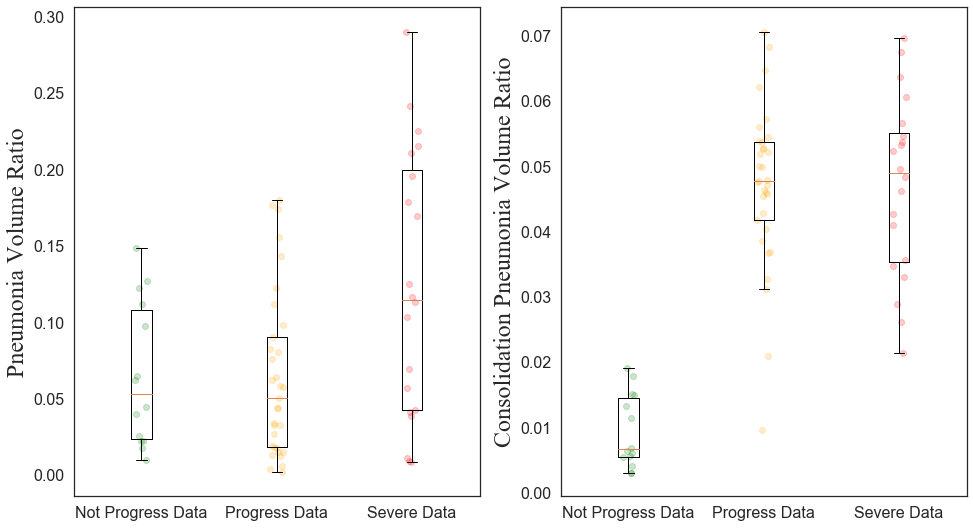

In [36]:
plt.subplots(figsize=(16, 9))
plt.subplot(1, 2, 1)
plot_data = {'Not Progress Data': not_progress_data['ratio'], 'Progress Data': progress_data['ratio'], 'Severe Data': severe_progress_data['ratio']}
box_plot_dict(plot_data, 'Pneumonia Volume Ratio', yscale='linear')
plt.subplot(1, 2, 2)
plot_data = {'Not Progress Data': not_progress_data['consolidation']/not_progress_data['lung'], 'Progress Data': progress_data['lesion_consolidation']/progress_data['lung'], 'Severe Data': severe_progress_data['lesion_consolidation']/severe_progress_data['lung']}
box_plot_dict(plot_data, 'Consolidation Pneumonia Volume Ratio', yscale='linear')

In [37]:
analysisRatio = clean_data_.copy()
analysisRatio['ratioType'] = 0

analysisConsolidation = clean_data_.copy()
analysisConsolidation['ratioType'] = 1
analysisConsolidation['ratio'] = analysisConsolidation['consolidation']/analysisConsolidation['lung']

analysisAll_ = pd.concat([analysisRatio, analysisConsolidation], axis=0)
analysisAll_ = analysisAll_.replace(-1, 2)

[(0.001, 1.0)]

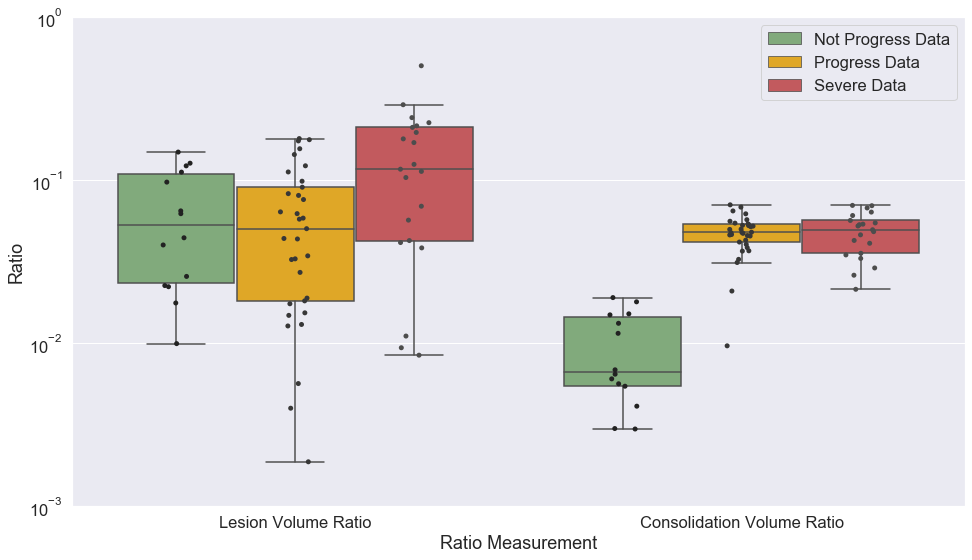

In [38]:
colors = ["faded green", "amber", "faded red", "medium blue"]
severes = ["mild patients", 'severe patients', 'critical patients']
#sns.palplot(sns.xkcd_palette(colors))
plt.figure(figsize=(16, 9))
sns.set(style="ticks")
sns.set(font_scale=1.5)
dx = sns.boxplot(x='ratioType', hue='progress', y='ratio', data=analysisAll_, palette=sns.xkcd_palette(colors),
                 boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(x='ratioType', hue='progress', y='ratio', data=analysisAll_,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
handles, _ = dx.get_legend_handles_labels()
dx.legend(handles, ['Not Progress Data', 'Progress Data', 'Severe Data'])
dx.set(xlabel='Ratio Measurement',ylabel='Ratio')
dx.set(xticklabels=['Lesion Volume Ratio','Consolidation Volume Ratio'])
dx.set_yscale("log")
dx.set(ylim=(0.001, 1.0))

In [39]:
ranksums(not_progress_data['consolidation'], progress_data['consolidation'])

RanksumsResult(statistic=-5.303759999271284, pvalue=1.1344143780440059e-07)

In [40]:
#clean_data.to_csv('analysisAll.csv')